## Oceanbolt Python SDK Lesson 1: Fleet Utilization

This is the first lesson in our learning series for the Oceanbolt Python SDK.

In this example, we are investigating fleet utilization for the Panamax fleet in 2020, applying two different methodologies for fleet utilization.

You can find an article with more context around the methodologies on our blog: https://www.oceanbolt.com/blog/

In [1]:
# Import the relevant libraries
# In order to be able to calculate fleet utilization we use the TonnageZoneTimeseries client and the TradeFlowTimeseries client.

from oceanbolt.sdk.client import APIClient
from oceanbolt.sdk.data.tonnage import TonnageZoneTimeseries
from oceanbolt.sdk.data.trade_flows import TradeFlowTimeseries
from datetime import date
import pandas as pd

In [65]:
# Create the base API client using your token. Tokens can be created in the Oceanbolt App (app.oceanbolt.com)
base_client = APIClient("<token>")

In [67]:
# Connect to the relevant Oceanbolt data endpoints using the base client object, ie: TonnageZoneTimeseries and TradeFlowTimeseries
tonnage_zone_client = TonnageZoneTimeseries(base_client)
trade_flow_client = TradeFlowTimeseries(base_client)

### Methodology 1: Ton-Days Demand / Supply

In [68]:
# We start by getting the panamax fleet count and volume on a daily basis (we will need the daily granularity later).
df1 = tonnage_zone_client.get(
    sub_segment=['panamax'], #We select the vessel sub-segment of Panamaxes in DWT68k-80k. A list of all available segments can be achieved by calling our Segments Entities API (https://python-sdk.oceanbolt.com/entities_v3/segments.html).
    start_date=date(2020, 1, 1), 
    end_date=date(2020, 12, 31),  
)

#Print 1 first rows of table
df1.head(1)

,date,vessel_count,vessel_dwt
0,2020-01-01,1161,87319872.0


In [77]:
# To convert the fleet into available capacity, we need to apply a standard duration for a panamax voyage. 
# Here we run into an issue of creating a daily timeseries it would require us to layer in additional assumptions. 
# To circumvent this, we aggregate available tonnage to an annual figure in Ton-Days. 
# We calculate the average tonnage and multiply by 366 days (number of days in 2020) in order get the theoretical maximum utilization of vessels (i.e. in fully laden condition every day of the day). Yes, this is unrealistic.

total_panamax_capacity = df1['vessel_dwt'].mean(axis=0)*366
total_panamax_capacity

31860280700.0

In [81]:
# The 31,860,280,700 ton-days is our supply assuming that all vessels are fully employed everyday (it is arguably a very unreasonable assumption). 
# Next for ton-days demand we get the emperically observed volume x duration metric. 
df_1_2 = trade_flow_client.get(
    frequency = "yearly", #Specify frequency, in our case we want daily flows
    metric = "volume_times_duration", #Specify the metric to get ton-days demand
    sub_segment=['panamax'],
    start_date=date(2020, 1, 1), 
    end_date=date(2020, 12, 31),
)
df_1_2['value']/total_panamax_capacity

0    0.605537
Name: value, dtype: float64

So according to this metric, the Panamax fleet was only 61% employed during 2020. It is hard to believe, but we also made a strong (and unreasonable) assumption on the supply of vessels. We are not really happy with this result. Let us see if we can do better.

We turn to another metric for calculating fleet utilization, namely the "employed vessels" metric. While crude in its economic rationale, it offers the advantages of being simple to calculate, easy to understand and most importantly offers the ability to create a daily timeseries without making any additional assumptions. 

The the "employed vessels" methodology simply counts the total number of vessels ballasting at sea (making a crude assumption that these vessels are not employed) and measures this tonnage as the available tonnage. Utilization thus becomes employed tonnage divided by total tonnage.

### Methodology 2: Employed vessels

In [92]:
# We apply filters to our query to get the time series of ballasting Panamax vessels
# A complete list of available filters can be found at https://python-sdk.oceanbolt.com/tonnage_v3/zone_count.html#arguments

df2 = tonnage_zone_client.get(
    sub_segment=['panamax'], # We select Panamax vessels
    laden_status=["ballast"], # We select Panamax vessels that are ballasting
    port_status=["at_sea"], # We select Panamax vessels that are ballasting at sea
    start_date=date(2020, 1, 1), 
    end_date=date(2020, 12, 31),  
)

#Print the first rows of table
df2.head(1)

,date,vessel_count,vessel_dwt
0,2020-01-01,189,14253705.0


<AxesSubplot:title={'center':'Oceanbolt 2020 Panamax Fleet Utilzation'}, xlabel='date'>

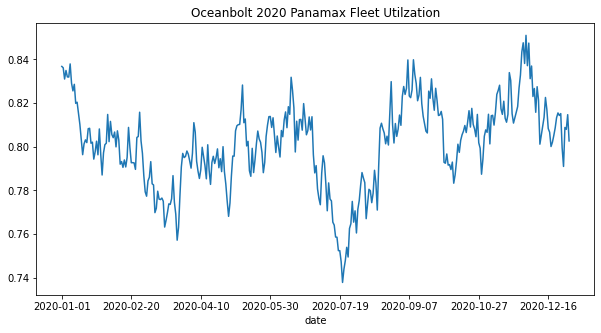

In [114]:
# We have already fetched the timeseries of total Panamaxes and their tonnage. We use this to calculate the daily utilization

df3 = pd.DataFrame(1-df2['vessel_dwt']/df1['vessel_dwt'])
df3['date'] = df1['date']
df3.plot(x='date', figsize=(10,5), title='Oceanbolt 2020 Panamax Fleet Utilzation', legend=False)

We have a daily timeseries! Yay!

Now what? The question that is on everyone's mind is probably: "Does fleet utilization correlate with freight rates?"

We might do a full deep-dive on how to compared this metric to rates by building a simple machine learning model. But for now we will leave it to practitioners to complete this exercise.

In [110]:
# Let us check if we get a more realistice annual utilization figure for the Panamax fleet.
df3['vessel_dwt'].mean(axis=0).round(3)

0.801

By using the employed vessels methodology, we get 80% utilization for the Panamax fleet in 2020.

Thanks for reading this! If you are interesting in getting access to our data, sign up for a product demo on https://www.oceanbolt.com/demo/